In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import fftpack
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (22, 6)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fftpack', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df = pd.read_csv('Data/BMS/Rooms and HVAC/RCU middenhal.csv', delimiter=';', encoding='utf-8')

In [3]:
df_temp = df[['Tijdstip', 'Gemiddelde ruimtetemp [°C] - RCU Middelhal 255 ()']]
df_temp.is_copy = False
df_temp.columns = ['Time', 'Temperature']

In [4]:
df_temp.is_copy = False
df_temp['Time'] = pd.to_datetime(df_temp['Time'], format="%d-%m-%Y %H:%M.%S")

df_temp['Temperature'] = [str(x).replace(',', '.') for x in df_temp['Temperature']]
df_temp['Temperature'] = pd.to_numeric(df_temp['Temperature'], errors='coerce')

In [5]:
df_temp.sort_values(['Time'], inplace=True)

In [6]:
df_temp = df_temp.loc[df_temp['Time'] > datetime.datetime(2017, 10, 23, 9, 0, 0)]
df_temp = df_temp.loc[df_temp['Time'] <= datetime.datetime(2018, 3, 8, 4, 52, 0)]

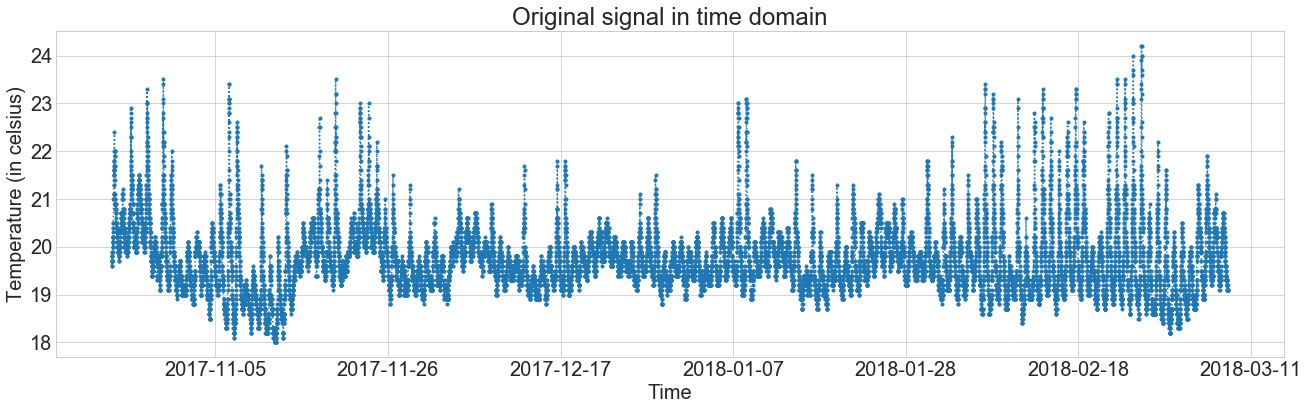

In [14]:
plt.plot(df_temp['Time'], df_temp['Temperature'], linestyle=':', marker='.')
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

In [8]:
demean = lambda df: df - df.mean()
time = pd.DatetimeIndex(df_temp['Time'])
grouped = df_temp.groupby([time.year, time.month, time.day])

In [9]:
def normalize(row, mean):

    return (row - mean)/mean

def scale(row, mean):

    return (row - mean)

norm_df = pd.DataFrame()

date_list = []
mean_temp_list = []

for name, group in grouped:
    df_sub = pd.DataFrame(group)
    date_list.append(name)
    mean = df_sub['Temperature'].mean()
    mean_temp_list.append(mean)
    df_sub['Temperature_normalized'] = df_sub.apply(lambda row: normalize(row['Temperature'], mean), axis=1)
    df_sub['Temperature_scaled'] = df_sub.apply(lambda row: scale(row['Temperature'], mean), axis=1)
    norm_df = norm_df.append(df_sub)

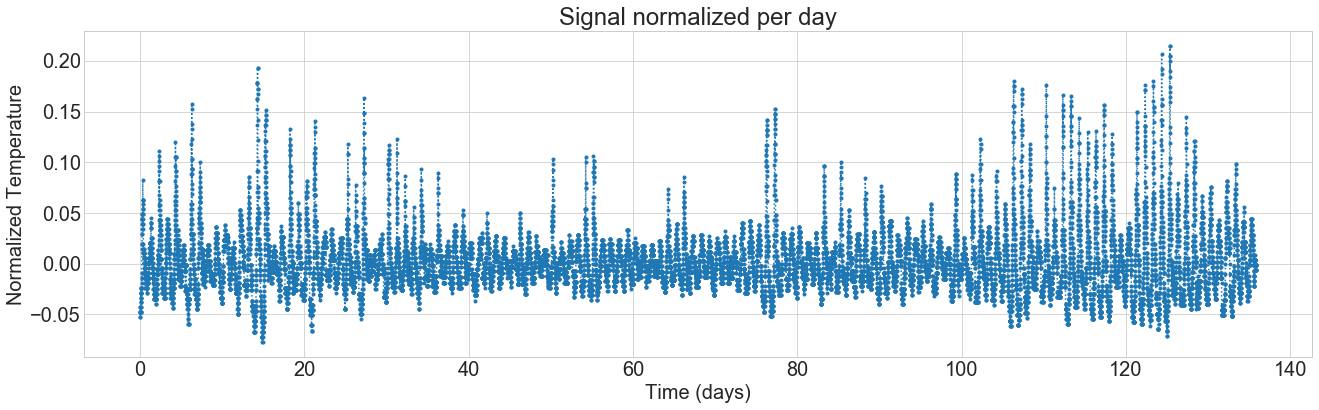

In [19]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(norm_df['Temperature_normalized'])+1)] 
plt.plot(x_range, norm_df['Temperature_normalized'], linestyle=':', marker='.')
plt.title('Signal normalized per day')
plt.ylabel('Normalized Temperature')
plt.xlabel('Time (days)')
plt.show()

In [52]:
mean1 = np.mean(mean_temp_list)
new_mean_list = [(i-mean1)/mean1 for i in mean_temp_list]

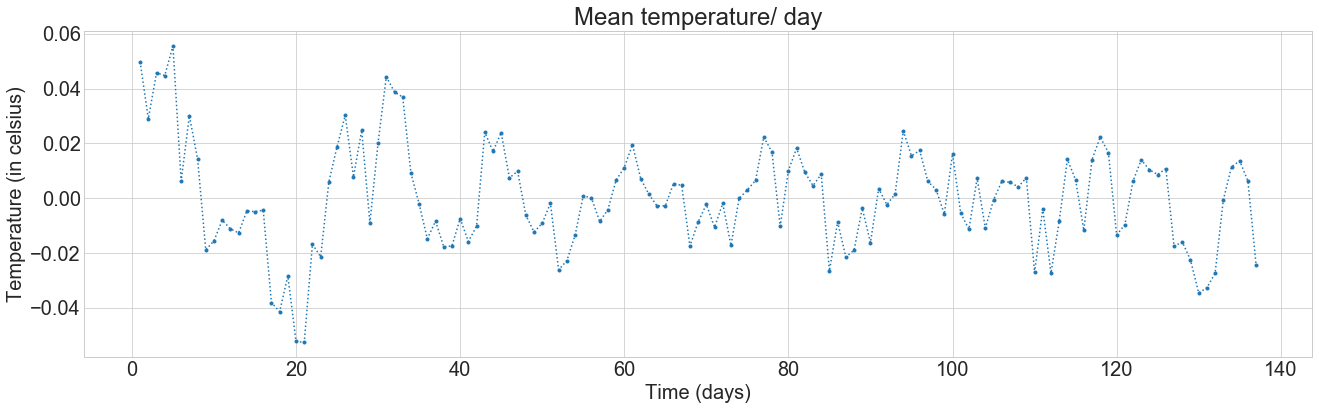

In [59]:
pylab.rcParams['figure.figsize'] = (22, 6)
plt.plot(range(1, len(mean_temp_list)+1), new_mean_list, linestyle=':', marker='.')
plt.title('Mean temperature/ day')
plt.ylabel('Temperature (in celsius)')
plt.xlabel('Time (days)')
plt.show()

In [55]:
X_temp_norm = np.fft.fft(norm_df['Temperature_normalized'], norm="ortho")
X_temp_scaled = np.fft.fft(norm_df['Temperature_scaled'], norm="ortho")
X_temp_mean = np.fft.fft(new_mean_list, norm="ortho")

In [46]:
freqs_norm = np.fft.fftfreq(len(norm_df['Temperature_normalized'])) * (1/480)
freqs_scaled = np.fft.fftfreq(len(norm_df['Temperature_scaled'])) * (1/480)
freqs_mean = np.fft.fftfreq(len(mean_temp_list))

Text(0.5,1,'DFT')

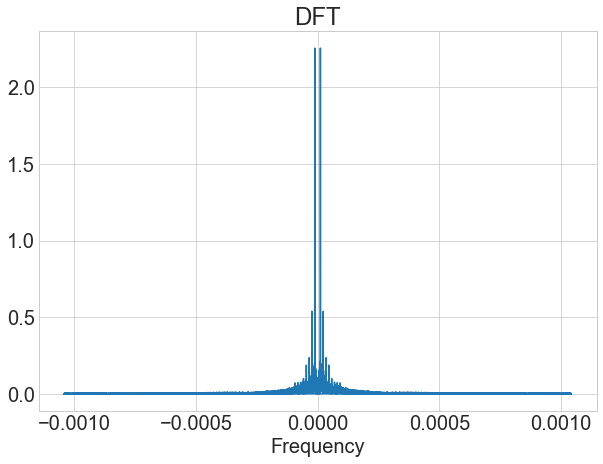

In [47]:
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(freqs_norm, abs(X_temp_norm))
plt.xlabel('Frequency')
plt.title('DFT')

Text(0.5,1,'DFT')

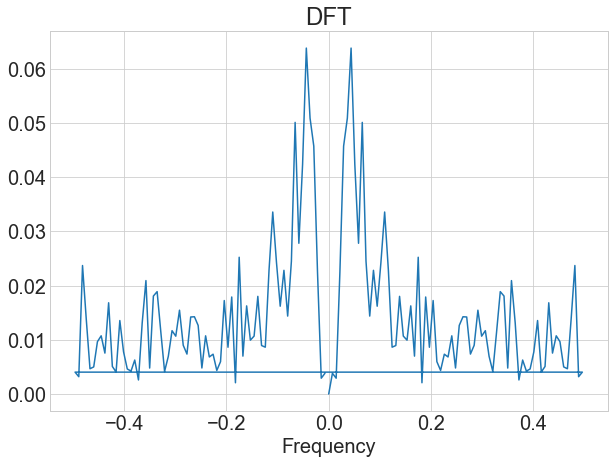

In [57]:
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(freqs_mean, abs(X_temp_mean))
plt.xlabel('Frequency')
plt.title('DFT')

In [51]:
abs(X_temp_mean)

array([  2.70036291e+03,   8.83652693e-01,   6.73142909e-01,
         5.17955505e+00,   1.05557438e+01,   1.17461017e+01,
         1.47283409e+01,   9.77796983e+00,   6.41747859e+00,
         1.15646428e+01,   5.65665274e+00,   3.31773821e+00,
         5.26581302e+00,   3.73813236e+00,   5.59997041e+00,
         7.74822602e+00,   5.27054768e+00,   1.99348009e+00,
         2.06407357e+00,   4.15718178e+00,   2.46625717e+00,
         2.29325064e+00,   3.75173661e+00,   1.61271396e+00,
         5.82224497e+00,   4.79056524e-01,   4.13007291e+00,
         1.99050449e+00,   3.97860260e+00,   1.37814691e+00,
         1.00362565e+00,   1.69500823e+00,   1.57693600e+00,
         2.47707975e+00,   1.10768057e+00,   2.91995583e+00,
         3.28898632e+00,   3.27900803e+00,   1.70003953e+00,
         2.07460579e+00,   3.56851546e+00,   2.46216743e+00,
         2.69623643e+00,   1.60313394e+00,   9.61253649e-01,
         2.62686554e+00,   4.35819892e+00,   4.17109844e+00,
         1.10454816e+00,

In [82]:
num = len(X_temp_norm)/2
num

12225.0

In [36]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

Text(0.5,1,'DFT')

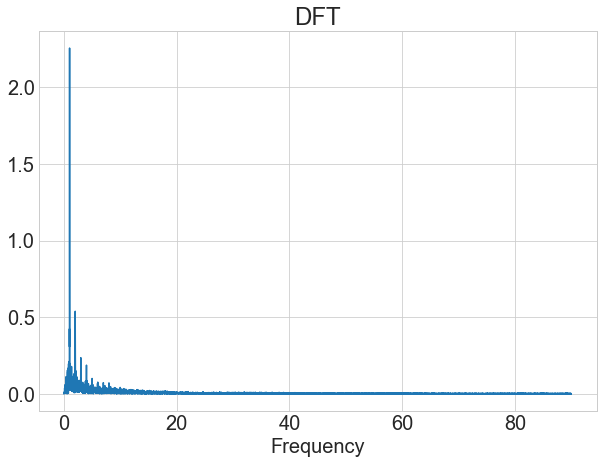

In [89]:
Fs = 1/480
y = X_temp_norm
resolution = Fs/(len(y))
n = np.arange(0, len(y))
f = n * resolution
pylab.rcParams['figure.figsize'] = (10, 7)
f_new = [i*8*10800 for i in f]
half = len(f_new)/2
plt.plot(f_new[:int(half)], abs(y[:int(half)]))
plt.xlabel('Frequency')
plt.title('DFT')

Text(0.5,1,'DFT')

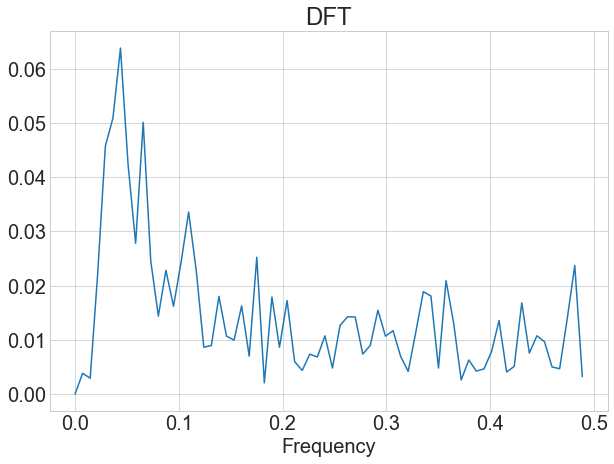

In [98]:
Fs3 = 1
y3 = X_temp_mean
resolution3 = Fs3/len(y3)
n3 = np.arange(0, len(y3))
f3 = n3 * resolution3
pylab.rcParams['figure.figsize'] = (10, 7)
f_new3 = f3
half3 = len(f_new3)/2
plt.plot(f_new3[:int(half3)], abs(y3[:int(half3)]))
plt.xlabel('Frequency')
plt.title('DFT')

In [121]:
filtered_y3 = [i if abs(i)>0.025 else 0 for i in y3]
reconstructed3 = np.fft.ifft(filtered_y3, norm="ortho")

C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


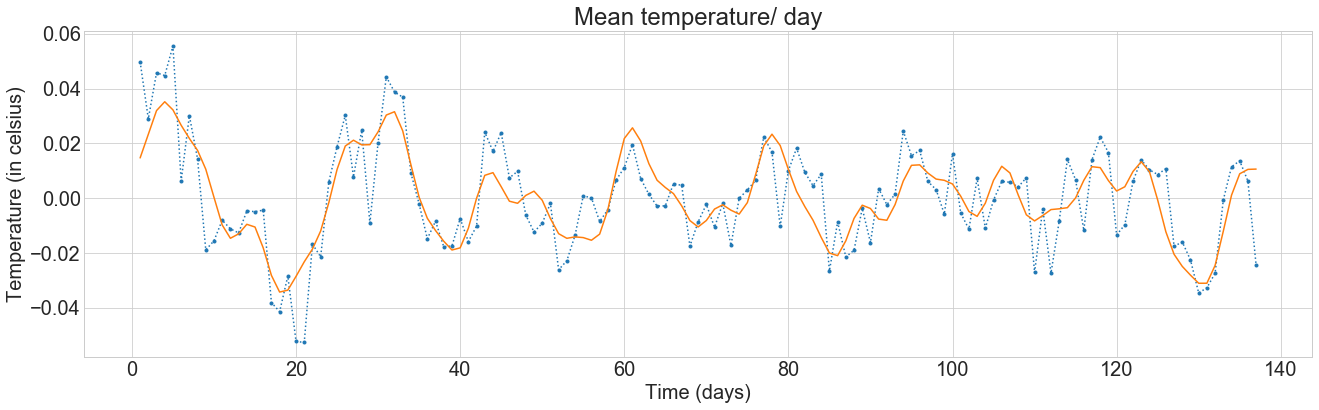

In [122]:
pylab.rcParams['figure.figsize'] = (22, 6)
plt.plot(range(1, len(mean_temp_list)+1), new_mean_list, linestyle=':', marker='.')
plt.title('Mean temperature/ day')
plt.ylabel('Temperature (in celsius)')
plt.xlabel('Time (days)')
plot(range(1, len(mean_temp_list)+1), reconstructed3)
plt.show()

In [56]:

print(f_new[-1])

89.9926380368


In [47]:
for i in range(len(y[:12587])):
    if abs(y[i])>0.5:
        print(f_new[i])
        print(abs(y[i]))

0.993865030675
0.523901817088
1.00122699387
2.25419593664
1.00858895706
0.863795554968
2.00245398773
0.539117489923


In [41]:
60*24*7.5

10800.0

In [35]:
[k for k in range(len(y))if abs(y[k]) > 1.5]

[136, 24314]

In [16]:
X_temp_norm_5 = [k  if abs(k) > 5 else 0 for k in X_temp_norm]
X_temp_norm_10 = [k  if abs(k) > 10 else 0 for k in X_temp_norm]
X_temp_norm_50 = [k  if abs(k) > 50 else 0 for k in X_temp_norm]
X_temp_norm_100 = [k  if abs(k) > 100 else 0 for k in X_temp_norm]
X_temp_norm_250 = [k  if abs(k) > 250 else 0 for k in X_temp_norm]

In [19]:
x_orig = np.fft.ifft(X_temp_norm)
x_reconstruct_5 = np.fft.ifft(X_temp_norm_5)
x_reconstruct_10 = np.fft.ifft(X_temp_norm_10)
x_reconstruct_50 = np.fft.ifft(X_temp_norm_50)
x_reconstruct_100 = np.fft.ifft(X_temp_norm_100)
x_reconstruct_250 = np.fft.ifft(X_temp_norm_250)

C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


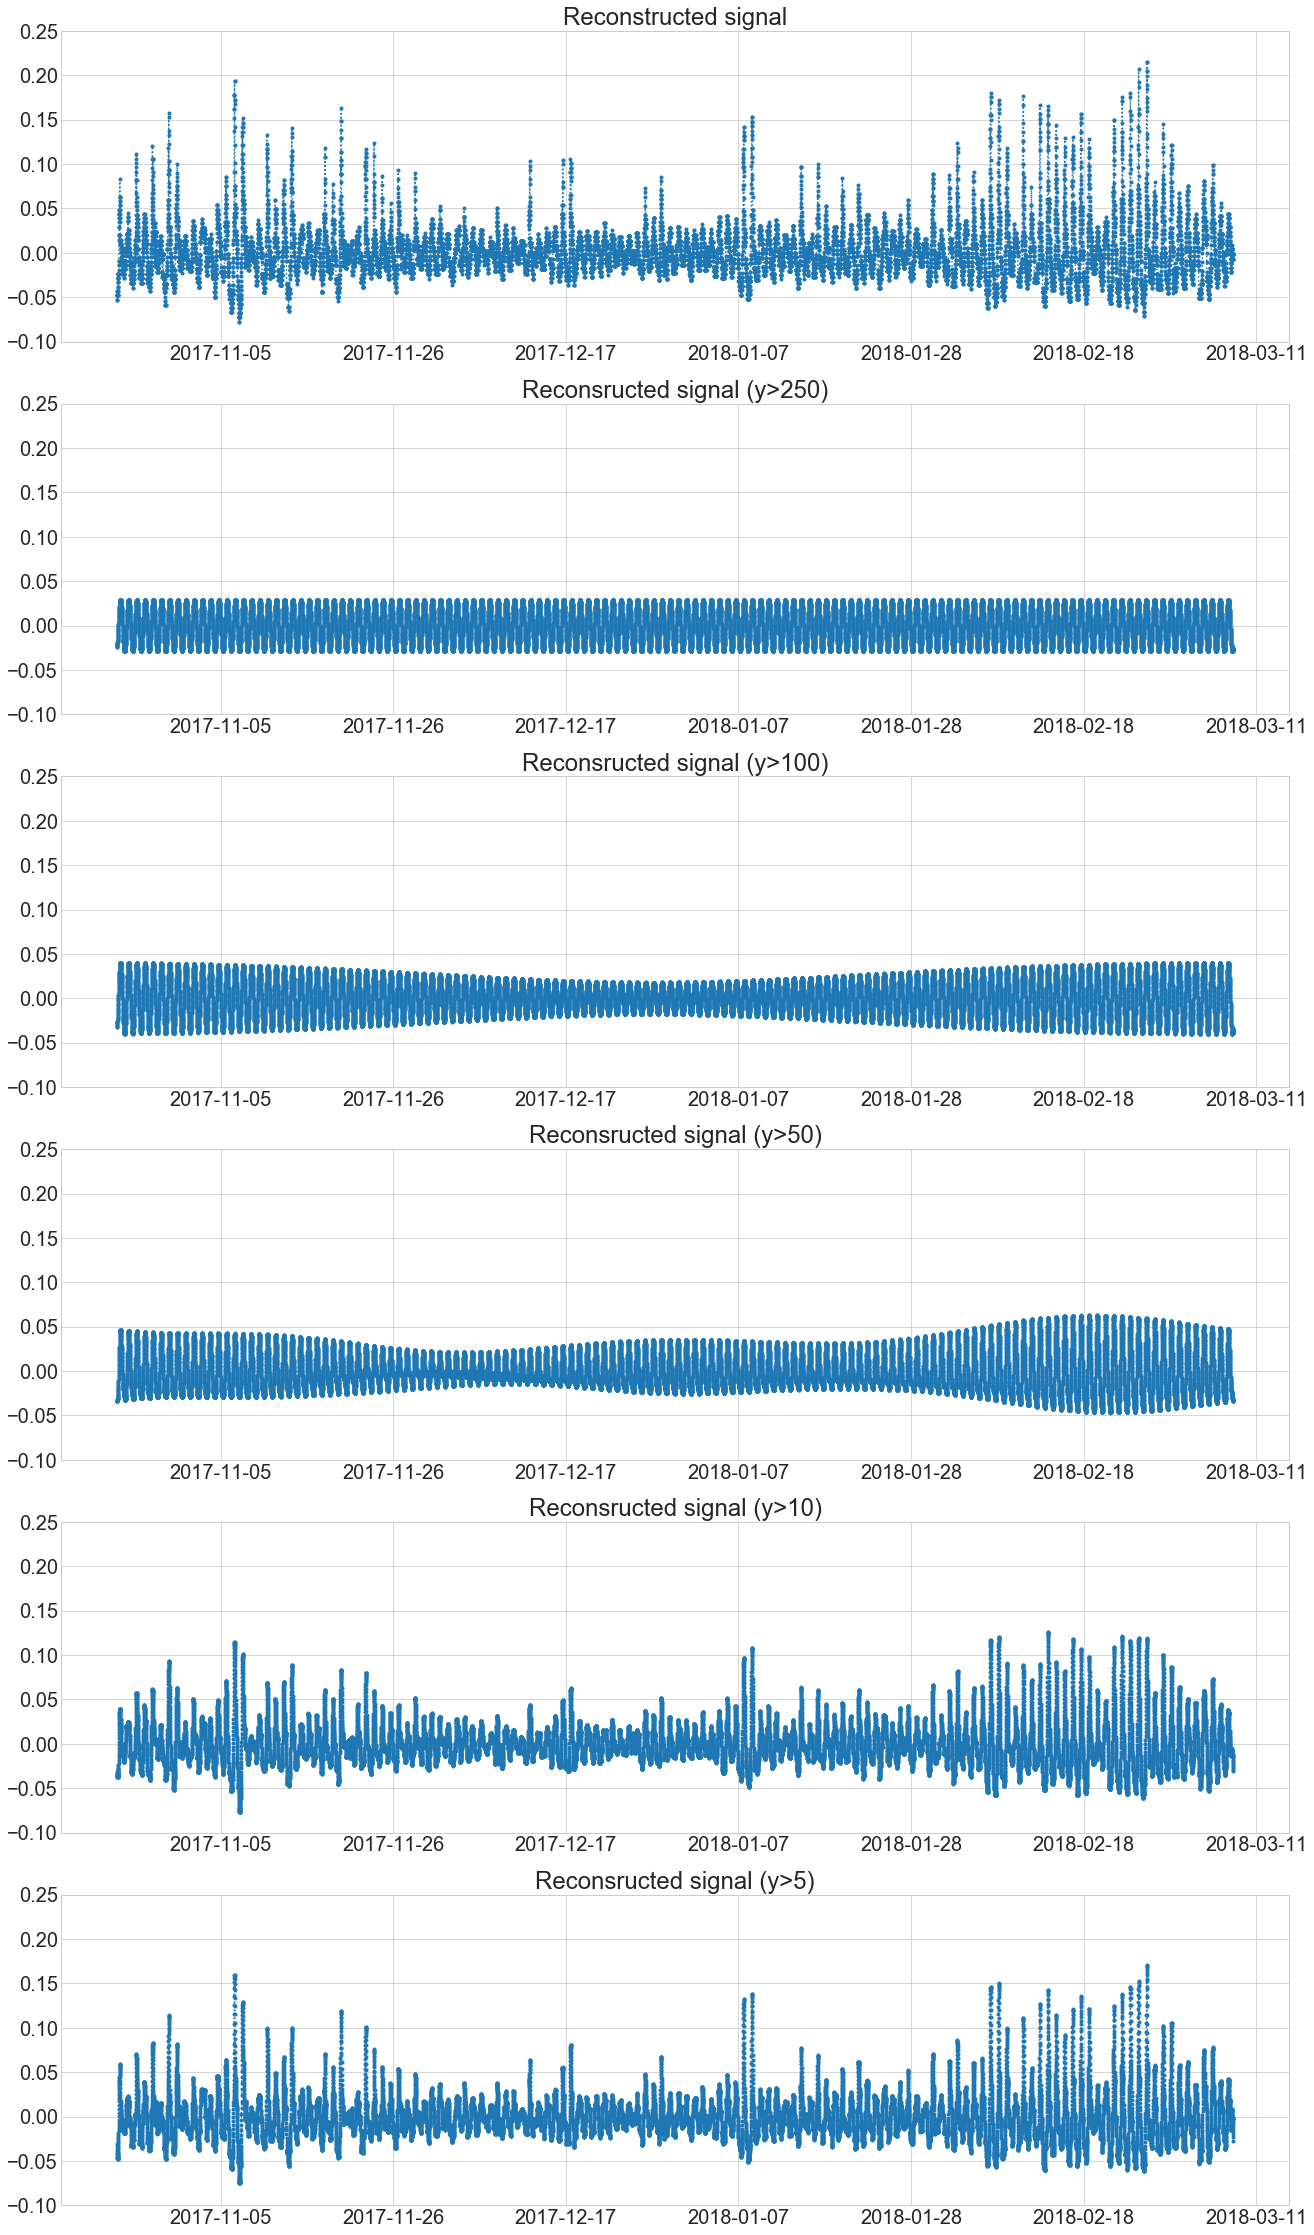

In [21]:
pylab.rcParams['figure.figsize'] = (22, 40)
plt.subplots_adjust(wspace=8)
plt.subplot(611)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconstructed signal')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], norm_df['Temperature_normalized'], linestyle=':', marker='.')

plt.subplot(612)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>250)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_250, linestyle=':', marker='.')

plt.subplot(613)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>100)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_100, linestyle=':', marker='.')

plt.subplot(614)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>50)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_50, linestyle=':', marker='.')

plt.subplot(615)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>10)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_10, linestyle=':', marker='.')

plt.subplot(616)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>5)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_5, linestyle=':', marker='.')

In [22]:
norm_df.sort_values(['Time'], inplace=True)
norm_df.reset_index(drop=True, inplace=True)

In [23]:
normalized_y =norm_df['Temperature_normalized'].rolling(window=180).mean()
normalized_y.fillna(0, inplace=True)

In [24]:
# pylab.rcParams['figure.figsize'] = (22, 8)
# plt.plot(normalized_y)

In [26]:
# new_t = [(m*480)/(60*60*24) for m in range(len(x_orig))]

In [27]:
# plt.plot(new_t, x_orig)